In [1]:
import os
import pandas as pd
import optuna
from qiskit.circuit import QuantumCircuit

import qtpu

from benchmark._plot_util import *

In [2]:
# NUM_QUBITS = 100

SUBCIRCUIT_SIZE = 20
CSV_FILE = "cost_anal.csv"

In [3]:
from qtpu.compiler.compiler import trial_to_circuit


def _min_cost_circuit(study: optuna.Study) -> QuantumCircuit:
    best_trial = min(study.best_trials, key=lambda trial: trial.values[0])
    return trial_to_circuit(best_trial)

In [7]:
from qtpu.compiler.compiler import compile_reach_size
from benchmark.ckt import cut_ckt, run_ckt
from benchmark.util import ckt_cost, qtpu_cost
import time
from qiskit_aer.primitives import Sampler


def get_result(circuit: QuantumCircuit):
    start = time.perf_counter()
    ckt_circ = cut_ckt(circuit, SUBCIRCUIT_SIZE)
    end = time.perf_counter()
    print(f"ckt: {end-start}")

    start = time.perf_counter()
    qtpu_circuit = compile_reach_size(circuit, SUBCIRCUIT_SIZE, show_progress_bar=True)
    end = time.perf_counter()
    print(f"qtpu: {end-start}")

    return {"ckt_cost": ckt_cost(ckt_circ), "qtpu_cost": qtpu_cost(qtpu_circuit)}

In [8]:
from benchmark.ansatz import generate_ansatz


BENCHMARKS = [
    {"name": "zz", "num_qubits": q, "depth": d}
    for q in [30, 40, 70, 100]
    for d in range(1, 4)
]

In [9]:
from benchmark.util import append_to_csv

# optuna.logging.set_verbosity(optuna.logging.INFO)

for bench in BENCHMARKS:
    circuit = generate_ansatz(**bench)

    result = get_result(circuit)
    print(result)
    append_to_csv(CSV_FILE, {**bench, **result})

      ┌───┐  ┌──────────┐                                               
 q_0: ┤ H ├──┤ P(1.929) ├───■─────────────────■─────────────────────────
      ├───┤┌─┴──────────┴┐┌─┴─┐┌───────────┐┌─┴─┐                       
 q_1: ┤ H ├┤ P(0.061962) ├┤ X ├┤ P(13.544) ├┤ X ├──■─────────────────■──
      ├───┤└┬───────────┬┘└───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐
 q_2: ┤ H ├─┤ P(2.0616) ├───■─────────────────■──┤ X ├┤ P(13.132) ├┤ X ├
      ├───┤ ├───────────┤ ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘
 q_3: ┤ H ├─┤ P(2.3184) ├─┤ X ├┤ P(8.3689) ├┤ X ├──■─────────────────■──
      ├───┤ ├───────────┤ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐
 q_4: ┤ H ├─┤ P(2.8437) ├───■─────────────────■──┤ X ├┤ P(6.8184) ├┤ X ├
      ├───┤ ├───────────┴┐┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘
 q_5: ┤ H ├─┤ P(0.16203) ├┤ X ├┤ P(10.527) ├┤ X ├──■─────────────────■──
      ├───┤ ├───────────┬┘└───┘└───────────┘└───┘┌─┴─┐ ┌──────────┐┌─┴─┐
 q_6: ┤ H ├─┤ P(2.8295) ├───■─────────────────■──┤ 

  0%|          | 0/100 [00:00<?, ?it/s]

qtpu: 3.51921148004476
{'ckt_cost': 8, 'qtpu_cost': 20}
      ┌───┐ ┌───────────┐                        ┌───┐┌───────────┐          »
 q_0: ┤ H ├─┤ P(3.0025) ├───■─────────────────■──┤ H ├┤ P(3.0025) ├──────────»
      ├───┤ ├───────────┴┐┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘     ┌───┐»
 q_1: ┤ H ├─┤ P(0.34789) ├┤ X ├┤ P(9.7358) ├┤ X ├──■─────────────────■──┤ H ├»
      ├───┤ ├───────────┬┘└───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤»
 q_2: ┤ H ├─┤ P(3.0199) ├───■─────────────────■──┤ X ├┤ P(9.6843) ├┤ X ├┤ H ├»
      ├───┤ ├───────────┴┐┌─┴─┐ ┌──────────┐┌─┴─┐└───┘└───────────┘└───┘├───┤»
 q_3: ┤ H ├─┤ P(0.38484) ├┤ X ├─┤ P(9.624) ├┤ X ├──■─────────────────■──┤ H ├»
      ├───┤ ├───────────┬┘└───┘ └──────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤»
 q_4: ┤ H ├─┤ P(1.8999) ├───■─────────────────■──┤ X ├┤ P(12.927) ├┤ X ├┤ H ├»
      ├───┤ ├───────────┴┐┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘├───┤»
 q_5: ┤ H ├─┤ P(0.88352) ├┤ X ├┤ P(11.834) ├┤ X ├──■─────────────────■──┤ H

  0%|          | 0/100 [00:00<?, ?it/s]

qtpu: 18.844601257005706
{'ckt_cost': 288, 'qtpu_cost': 736}
      ┌───┐ ┌───────────┐                        ┌───┐┌───────────┐          »
 q_0: ┤ H ├─┤ P(0.9836) ├───■─────────────────■──┤ H ├┤ P(0.9836) ├──────────»
      ├───┤ ├───────────┤ ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘     ┌───┐»
 q_1: ┤ H ├─┤ P(1.4741) ├─┤ X ├┤ P(12.743) ├┤ X ├──■─────────────────■──┤ H ├»
      ├───┤ ├───────────┤ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤»
 q_2: ┤ H ├─┤ P(1.4443) ├───■─────────────────■──┤ X ├┤ P(11.635) ├┤ X ├┤ H ├»
      ├───┤ ├───────────┤ ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘├───┤»
 q_3: ┤ H ├─┤ P(1.5337) ├─┤ X ├┤ P(11.491) ├┤ X ├──■─────────────────■──┤ H ├»
      ├───┤ ├───────────┴┐└───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤»
 q_4: ┤ H ├─┤ P(0.88374) ├──■─────────────────■──┤ X ├┤ P(12.822) ├┤ X ├┤ H ├»
      ├───┤ ├───────────┬┘┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘├───┤»
 q_5: ┤ H ├─┤ P(1.2839) ├─┤ X ├┤ P(13.497) ├┤ X ├──■─────────────────■

  0%|          | 0/100 [00:00<?, ?it/s]

/home/nate/qvm/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:307: UserWarning: Trial error: Optimization timed out. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(


qtpu: 43.96188587602228
{'ckt_cost': 46656, 'qtpu_cost': 25936}
      ┌───┐  ┌──────────┐                                               
 q_0: ┤ H ├──┤ P(2.217) ├───■─────────────────■─────────────────────────
      ├───┤ ┌┴──────────┤ ┌─┴─┐┌───────────┐┌─┴─┐                       
 q_1: ┤ H ├─┤ P(2.0306) ├─┤ X ├┤ P(8.6459) ├┤ X ├──■─────────────────■──
      ├───┤ ├───────────┤ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐
 q_2: ┤ H ├─┤ P(1.5534) ├───■─────────────────■──┤ X ├┤ P(10.057) ├┤ X ├
      ├───┤ ├───────────┴┐┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘
 q_3: ┤ H ├─┤ P(0.82789) ├┤ X ├┤ P(12.901) ├┤ X ├──■─────────────────■──
      ├───┤ └┬──────────┬┘└───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐
 q_4: ┤ H ├──┤ P(1.746) ├───■─────────────────■──┤ X ├┤ P(12.376) ├┤ X ├
      ├───┤ ┌┴──────────┤ ┌─┴─┐ ┌──────────┐┌─┴─┐└───┘└───────────┘└───┘
 q_5: ┤ H ├─┤ P(1.9726) ├─┤ X ├─┤ P(9.779) ├┤ X ├──■─────────────────■──
      ├───┤ └┬──────────┤ └───┘ └──────────┘└───┘┌─┴─┐┌─────

  0%|          | 0/100 [00:00<?, ?it/s]

qtpu: 5.005216250894591
{'ckt_cost': 36, 'qtpu_cost': 72}
      ┌───┐ ┌────────────┐                       ┌───┐┌────────────┐          »
 q_0: ┤ H ├─┤ P(0.86908) ├──■─────────────────■──┤ H ├┤ P(0.86908) ├──────────»
      ├───┤ ├───────────┬┘┌─┴─┐┌───────────┐┌─┴─┐└───┘└────────────┘     ┌───┐»
 q_1: ┤ H ├─┤ P(1.7483) ├─┤ X ├┤ P(12.276) ├┤ X ├──■──────────────────■──┤ H ├»
      ├───┤ ├───────────┴┐└───┘└───────────┘└───┘┌─┴─┐ ┌──────────┐ ┌─┴─┐├───┤»
 q_2: ┤ H ├─┤ P(0.35152) ├──■─────────────────■──┤ X ├─┤ P(13.45) ├─┤ X ├┤ H ├»
      ├───┤ └┬─────────┬─┘┌─┴─┐┌───────────┐┌─┴─┐└───┘ └──────────┘ └───┘├───┤»
 q_3: ┤ H ├──┤ P(0.25) ├──┤ X ├┤ P(17.893) ├┤ X ├──■──────────────────■──┤ H ├»
      ├───┤ ┌┴─────────┴─┐└───┘└───────────┘└───┘┌─┴─┐┌───────────┐ ┌─┴─┐├───┤»
 q_4: ┤ H ├─┤ P(0.31144) ├──■─────────────────■──┤ X ├┤ P(18.014) ├─┤ X ├┤ H ├»
      ├───┤ ├────────────┤┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘ └───┘├───┤»
 q_5: ┤ H ├─┤ P(0.12869) ├┤ X ├┤ P(18.377) ├┤ X ├──■──────────

  0%|          | 0/100 [00:00<?, ?it/s]

qtpu: 25.62969648593571
{'ckt_cost': 1296, 'qtpu_cost': 2592}
      ┌───┐ ┌───────────┐                        ┌───┐┌───────────┐           »
 q_0: ┤ H ├─┤ P(3.1015) ├───■─────────────────■──┤ H ├┤ P(3.1015) ├───────────»
      ├───┤ ├───────────┴┐┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘      ┌───┐»
 q_1: ┤ H ├─┤ P(0.33778) ├┤ X ├┤ P(9.4582) ├┤ X ├──■──────────────────■──┤ H ├»
      ├───┤ ├───────────┬┘└───┘└───────────┘└───┘┌─┴─┐┌───────────┐ ┌─┴─┐├───┤»
 q_2: ┤ H ├─┤ P(2.7858) ├───■─────────────────■──┤ X ├┤ P(10.397) ├─┤ X ├┤ H ├»
      ├───┤ ├───────────┴┐┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘ └───┘├───┤»
 q_3: ┤ H ├─┤ P(0.35731) ├┤ X ├┤ P(10.363) ├┤ X ├──■──────────────────■──┤ H ├»
      ├───┤ ├───────────┬┘└───┘└───────────┘└───┘┌─┴─┐┌───────────┐ ┌─┴─┐├───┤»
 q_4: ┤ H ├─┤ P(2.4146) ├───■─────────────────■──┤ X ├┤ P(11.462) ├─┤ X ├┤ H ├»
      ├───┤ ├───────────┤ ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘ └───┘├───┤»
 q_5: ┤ H ├─┤ P(1.8224) ├─┤ X ├┤ P(8.6285) ├┤ X ├──■──────

  0%|          | 0/100 [00:00<?, ?it/s]

qtpu: 52.512561099021696
{'ckt_cost': 46656, 'qtpu_cost': 93312}
      ┌───┐┌───────────┐                                               
 q_0: ┤ H ├┤ P(1.9543) ├───■─────────────────■─────────────────────────
      ├───┤├───────────┤ ┌─┴─┐┌───────────┐┌─┴─┐                       
 q_1: ┤ H ├┤ P(1.3125) ├─┤ X ├┤ P(10.759) ├┤ X ├──■─────────────────■──
      ├───┤├───────────┤ └───┘└───────────┘└───┘┌─┴─┐ ┌──────────┐┌─┴─┐
 q_2: ┤ H ├┤ P(3.1174) ├───■─────────────────■──┤ X ├─┤ P(7.868) ├┤ X ├
      ├───┤├───────────┤ ┌─┴─┐┌───────────┐┌─┴─┐└───┘ └──────────┘└───┘
 q_3: ┤ H ├┤ P(2.4001) ├─┤ X ├┤ P(6.1465) ├┤ X ├──■─────────────────■──
      ├───┤└┬──────────┤ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐
 q_4: ┤ H ├─┤ P(2.454) ├───■─────────────────■──┤ X ├┤ P(7.4345) ├┤ X ├
      ├───┤┌┴──────────┤ ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘
 q_5: ┤ H ├┤ P(2.7955) ├─┤ X ├┤ P(6.6775) ├┤ X ├──■─────────────────■──
      ├───┤├───────────┤ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐

  0%|          | 0/100 [00:00<?, ?it/s]

qtpu: 8.525430815992877
{'ckt_cost': 46656, 'qtpu_cost': 84}
      ┌───┐ ┌────────────┐                       ┌───┐┌────────────┐          »
 q_0: ┤ H ├─┤ P(0.51963) ├──■─────────────────■──┤ H ├┤ P(0.51963) ├──────────»
      ├───┤ └┬──────────┬┘┌─┴─┐ ┌──────────┐┌─┴─┐└───┘└────────────┘     ┌───┐»
 q_1: ┤ H ├──┤ P(0.783) ├─┤ X ├─┤ P(15.85) ├┤ X ├──■──────────────────■──┤ H ├»
      ├───┤ ┌┴──────────┴┐└───┘ └──────────┘└───┘┌─┴─┐┌───────────┐ ┌─┴─┐├───┤»
 q_2: ┤ H ├─┤ P(0.89222) ├──■─────────────────■──┤ X ├┤ P(14.826) ├─┤ X ├┤ H ├»
      ├───┤ ├───────────┬┘┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘ └───┘├───┤»
 q_3: ┤ H ├─┤ P(2.6524) ├─┤ X ├┤ P(9.7866) ├┤ X ├──■──────────────────■──┤ H ├»
      ├───┤ ├───────────┤ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐ ┌─┴─┐├───┤»
 q_4: ┤ H ├─┤ P(2.7314) ├───■─────────────────■──┤ X ├┤ P(6.4478) ├─┤ X ├┤ H ├»
      ├───┤ ├───────────┤ ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘ └───┘├───┤»
 q_5: ┤ H ├─┤ P(1.6802) ├─┤ X ├┤ P(8.1744) ├┤ X ├──■───────

  0%|          | 0/100 [00:00<?, ?it/s]

qtpu: 57.29680081491824
{'ckt_cost': 2176782336, 'qtpu_cost': 15712}
      ┌───┐  ┌──────────┐                         ┌───┐ ┌──────────┐          »
 q_0: ┤ H ├──┤ P(2.791) ├────■─────────────────■──┤ H ├─┤ P(2.791) ├──────────»
      ├───┤ ┌┴──────────┴┐ ┌─┴─┐┌───────────┐┌─┴─┐└───┘ └──────────┘     ┌───┐»
 q_1: ┤ H ├─┤ P(0.99274) ├─┤ X ├┤ P(9.2375) ├┤ X ├──■─────────────────■──┤ H ├»
      ├───┤ ├───────────┬┘ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤»
 q_2: ┤ H ├─┤ P(2.0704) ├────■─────────────────■──┤ X ├┤ P(11.144) ├┤ X ├┤ H ├»
      ├───┤ └┬──────────┤  ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘├───┤»
 q_3: ┤ H ├──┤ P(1.914) ├──┤ X ├┤ P(9.2031) ├┤ X ├──■─────────────────■──┤ H ├»
      ├───┤ ┌┴──────────┤  └───┘└───────────┘└───┘┌─┴─┐ ┌──────────┐┌─┴─┐├───┤»
 q_4: ┤ H ├─┤ P(1.1334) ├────■─────────────────■──┤ X ├─┤ P(11.25) ├┤ X ├┤ H ├»
      ├───┤ ├───────────┤  ┌─┴─┐┌───────────┐┌─┴─┐└───┘ └──────────┘└───┘├───┤»
 q_5: ┤ H ├─┤ P(1.2564) ├──┤ X ├┤ P(12.944) ├┤ X ├─

  0%|          | 0/100 [00:00<?, ?it/s]

/home/nate/qvm/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:307: UserWarning: Trial error: Optimization timed out. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(


qtpu: 111.05290083505679
{'ckt_cost': 101559956668416, 'qtpu_cost': 80725264}
      ┌───┐ ┌────────────┐                                              
 q_0: ┤ H ├─┤ P(0.33393) ├──■─────────────────■─────────────────────────
      ├───┤ ├───────────┬┘┌─┴─┐┌───────────┐┌─┴─┐                       
 q_1: ┤ H ├─┤ P(2.4851) ├─┤ X ├┤ P(11.298) ├┤ X ├──■─────────────────■──
      ├───┤ ├───────────┤ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐
 q_2: ┤ H ├─┤ P(2.5144) ├───■─────────────────■──┤ X ├┤ P(7.1571) ├┤ X ├
      ├───┤ ├───────────┤ ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘
 q_3: ┤ H ├─┤ P(1.0763) ├─┤ X ├┤ P(9.8117) ├┤ X ├──■─────────────────■──
      ├───┤ ├───────────┤ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐
 q_4: ┤ H ├─┤ P(2.3752) ├───■─────────────────■──┤ X ├┤ P(10.174) ├┤ X ├
      ├───┤ ├───────────┴┐┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘└───┘
 q_5: ┤ H ├─┤ P(0.44789) ├┤ X ├┤ P(11.402) ├┤ X ├──■─────────────────■──
      ├───┤ ├────────────┤└───┘└───────────┘└─

  0%|          | 0/100 [00:00<?, ?it/s]

qtpu: 14.889086376060732
{'ckt_cost': 1679616, 'qtpu_cost': 212}
      ┌───┐ ┌───────────┐                         ┌───┐┌───────────┐           »
 q_0: ┤ H ├─┤ P(1.0414) ├────■─────────────────■──┤ H ├┤ P(1.0414) ├───────────»
      ├───┤ ├───────────┤  ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘      ┌───┐»
 q_1: ┤ H ├─┤ P(0.3489) ├──┤ X ├┤ P(15.553) ├┤ X ├──■──────────────────■──┤ H ├»
      ├───┤ ├───────────┴┐ └───┘└───────────┘└───┘┌─┴─┐┌───────────┐ ┌─┴─┐├───┤»
 q_2: ┤ H ├─┤ P(0.59367) ├───■─────────────────■──┤ X ├┤ P(16.882) ├─┤ X ├┤ H ├»
      ├───┤ ├───────────┬┘ ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘ └───┘├───┤»
 q_3: ┤ H ├─┤ P(1.6472) ├──┤ X ├┤ P(13.188) ├┤ X ├──■──────────────────■──┤ H ├»
      ├───┤ ├───────────┤  └───┘└───────────┘└───┘┌─┴─┐┌───────────┐ ┌─┴─┐├───┤»
 q_4: ┤ H ├─┤ P(1.5608) ├────■─────────────────■──┤ X ├┤ P(10.946) ├─┤ X ├┤ H ├»
      ├───┤ ├───────────┤  ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───────────┘ └───┘├───┤»
 q_5: ┤ H ├─┤ P(1.9377) ├──┤ X ├┤ P(10.261) 

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, CDKMRippleCarryAdder, TwoLocal, EfficientSU2
circuit = EfficientSU2(10, entanglement="circular").decompose()

print(circuit)

     ┌──────────┐┌───────────┐┌───┐     ┌───────────┐┌───────────┐             »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[10]) ├┤ X ├──■──┤ Ry(θ[20]) ├┤ Rz(θ[30]) ├─────────────»
     ├──────────┤├───────────┤└─┬─┘┌─┴─┐└───────────┘├───────────┤┌───────────┐»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[11]) ├──┼──┤ X ├──────■──────┤ Ry(θ[21]) ├┤ Rz(θ[31]) ├»
     ├──────────┤├───────────┤  │  └───┘    ┌─┴─┐    └───────────┘├───────────┤»
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[12]) ├──┼───────────┤ X ├──────────■──────┤ Ry(θ[22]) ├»
     ├──────────┤├───────────┤  │           └───┘        ┌─┴─┐    └───────────┘»
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[13]) ├──┼────────────────────────┤ X ├──────────■──────»
     ├──────────┤├───────────┤  │                        └───┘        ┌─┴─┐    »
q_4: ┤ Ry(θ[4]) ├┤ Rz(θ[14]) ├──┼─────────────────────────────────────┤ X ├────»
     ├──────────┤├───────────┤  │                                     └───┘    »
q_5: ┤ Ry(θ[5]) ├┤ Rz(θ[15]) ├──┼──────────────────────────────────────────────»
     ├──────────┤├──────────

In [ ]:
from benchmark._plot_util import *


def plot(benches: list[str], ax: plt.Axes):
    df = pd.read_csv(CSV_FILE)
    df = df[["name", "cutqc", "ckt", "scaleqc", "qtpu"]]
    # rename columns
    df = df.rename(
        columns={"qtpu": "QTPU", "scaleqc": "ScaleQC", "ckt": "CKT", "cutqc": "CutQC"}
    )
    df = df[df["name"].isin(benches)]
    df.sort_index()
    df_mean = 10 ** df.groupby("name").mean()
    df_std = df.groupby("name").std().reset_index().drop("name", axis=1)

    df_mean.plot.bar(
        rot=20,
        width=0.8,
        edgecolor="black",
        linewidth=2,
        ax=ax,
        legend=False,
        yerr=df_std.to_numpy().T,
    )
    ax.set_yscale("log")
    # ax.set_yticklabels([f"$10^{{{int(x.get_text())}}}$" for x in ax.get_yticklabels()])
    ax.set_title("Lower is better ↓", fontweight="bold", color="midnightblue")
    ax.set_xlabel("")
    ax.set_ylabel("Contraction Cost [FLOPs]")

KeyError: "['cutqc', 'ckt', 'scaleqc', 'qtpu'] not in index"

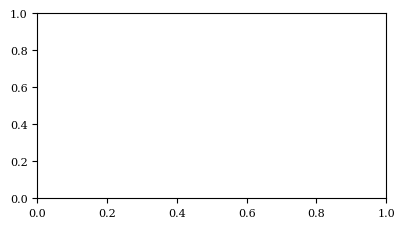

In [ ]:
benches_to_plot = [
    # f"qaoa_erdos_{NUM_QUBITS}_1",
    # f"qaoa_regular_{NUM_QUBITS}_1",
    # f"qaoa_power_{NUM_QUBITS}_1"
    "cluster_25_4_5",
    "cluster_25_4_4",
    "cluster_25_4_3",
    # "cluster_25_4_2",
    # # "cluster_25_4_1",
    # # "cluster_25_8_4",
    # # # "linear_200_1",
    # # "linear_100_2",
    "linear_100_3",
    "linear_100_4",
    # f"random_{NUM_QUBITS}_1",
    # f"random_{NUM_QUBITS}_2",
    # f"random_{NUM_QUBITS}_3",
    # f"random_{NUM_QUBITS}_4",
    # # # # "brick_100_1",
    # # "brick_100_2",
    "brick_100_3",
    "brick_100_4",
]


# df = pd.read_csv(CSV_FILE)
# df = df[df["name"].isin(benches_to_plot)]

# df = df.groupby("name").mean()


# # df.set_index(df.index.str.replace(f"_{NUM_QUBITS}_", "_"), inplace=True)
# # reorder columns
# # df = df[["qtpu", "scaleqc", "ckt", "cutqc"]]
WIDE_FIGSIZE = (4.5, 2.4)

fig, ax = plt.subplots(figsize=WIDE_FIGSIZE)
plot(benches_to_plot, ax)
# ax.set_ylim(0, 1e10)



ax.legend()

# import seaborn as sns

# colors = sns.color_palette("tab10", n_colors=4)

# df.plot.bar(rot=15, width=0.8, edgecolor="black", linewidth=2, ax=ax, color=colors, legend=False)

# # for ytick in ax.get_yticklabels():
# # ytick.set_text(f"$10^{{{ytick.get_text()}}}$")

# ax.set_yticklabels([f"$10^{{{int(x.get_text())}}}$" for x in ax.get_yticklabels()])
# ax.set_title("Lower is better", fontweight="bold", color="midnightblue")
# ax.set_xlabel("")
# fig;

In [ ]:
fig.savefig("cost.pdf", bbox_inches="tight")